In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Read in the data
df=pd.read_csv("https://raw.githubusercontent.com/statzenthusiast921/rotten-tomatoes-analysis/main/data/rotten_tomatoes_movies.csv")
print(df.shape)

(17712, 22)


In [2]:
df.head(2)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19


In [3]:
del df['rotten_tomatoes_link'], df['tomatometer_top_critics_count'], df['tomatometer_fresh_critics_count'], df['tomatometer_rotten_critics_count']

In [4]:
df.columns

Index(['movie_title', 'movie_info', 'critics_consensus', 'content_rating',
       'genres', 'directors', 'authors', 'actors', 'original_release_date',
       'streaming_release_date', 'runtime', 'production_company',
       'tomatometer_status', 'tomatometer_rating', 'tomatometer_count',
       'audience_status', 'audience_rating', 'audience_count'],
      dtype='object')

In [5]:
#Create new features
df[['og_year','og_month','og_day']] = df['original_release_date'].str.split('-',expand=True)
df[['str_year','str_month','str_day']] = df['streaming_release_date'].str.split('-',expand=True)
df['num_actors'] = df['actors'].str.count(',')+1

In [6]:
#Check missing
df.isnull().sum()

movie_title                  0
movie_info                 321
critics_consensus         8578
content_rating               0
genres                      19
directors                  194
authors                   1542
actors                     352
original_release_date     1166
streaming_release_date     384
runtime                    314
production_company         499
tomatometer_status          44
tomatometer_rating          44
tomatometer_count           44
audience_status            448
audience_rating            296
audience_count             297
og_year                   1166
og_month                  1166
og_day                    1166
str_year                   384
str_month                  384
str_day                    384
num_actors                 352
dtype: int64

In [7]:
df = df[(df['og_year'].notna()) & (df['str_year'].notna())]
df.shape

(16305, 25)

In [8]:
#Convert time features to integers
df['og_year'] = df['og_year'].astype(int)
df['str_year'] = df['str_year'].astype(int)

df['og_month'] = df['og_month'].astype(int)
df['str_month'] = df['str_month'].astype(int)

df['og_day'] = df['og_day'].astype(int)
df['str_day'] = df['str_day'].astype(int)

# Exploratory Data Analysis

#### 1.) Plot categorical data

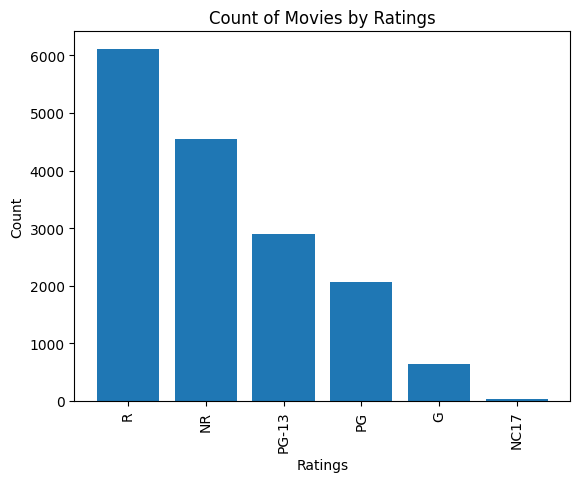

In [9]:
#Rating count
def make_bar_chart_from_frequencies(column_name,unique_values_to_include,xlabel):
    bar_df = pd.DataFrame(df[f'{column_name}'].value_counts()).reset_index().head(unique_values_to_include)
    
    bar_df = bar_df.rename(columns={
        bar_df.columns[0]: "col1" ,
        bar_df.columns[1]: "col2" 
    })

    plt.bar(bar_df['col1'],bar_df['col2'])
    plt.title(f'Count of Movies by {xlabel}')
    plt.xlabel(f'{xlabel}')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()
    
    
make_bar_chart_from_frequencies(
    'content_rating',len(df['content_rating'].value_counts()),'Ratings'
)

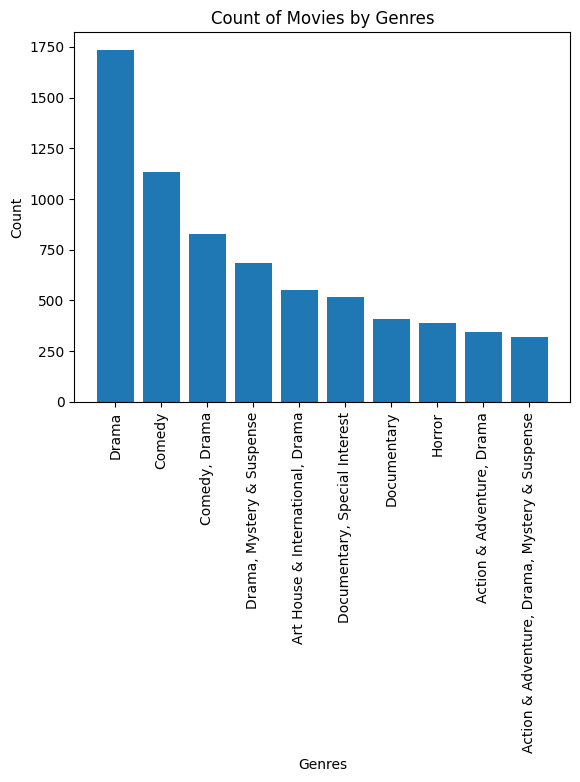

In [10]:
#Genre count
make_bar_chart_from_frequencies(
    'genres',10,'Genres'
)

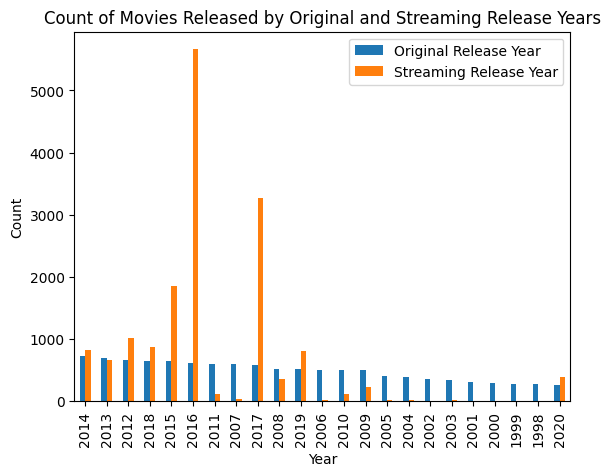

In [11]:
#Year count
bar_df = pd.DataFrame(df['og_year'].value_counts()).reset_index()
bar_df = bar_df.rename(columns={
    "index": "year", 
    "og_year": "og_count"
})

bar_df2 = pd.DataFrame(df['str_year'].value_counts()).reset_index()
bar_df2 = bar_df2.rename(columns={
    "index": "year", 
    "str_year": "str_count"
})

#Join og and streaming release years together
year_df = pd.merge(bar_df, bar_df2, on="year")

#Plot original release year side by side with streaming release year
year_df.set_index('year').plot.bar()
plt.ylabel('Count')
plt.xlabel('Year')
plt.title('Count of Movies Released by Original and Streaming Release Years')
L=plt.legend()
L.get_texts()[0].set_text('Original Release Year')
L.get_texts()[1].set_text('Streaming Release Year');

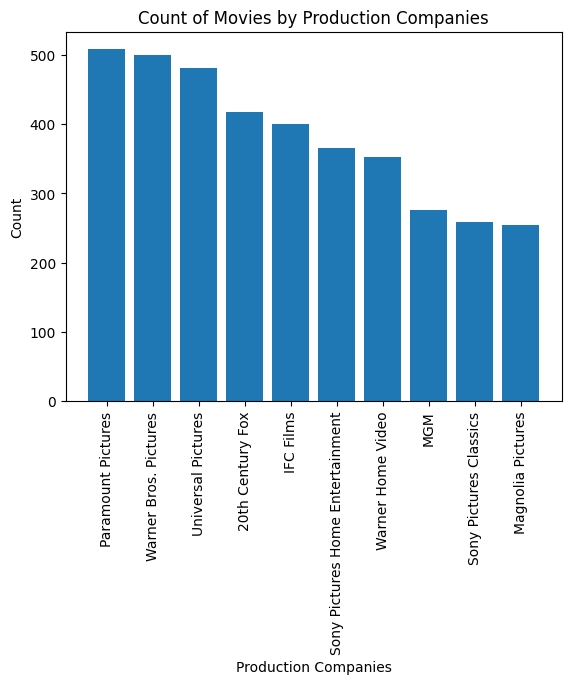

In [12]:
#Count of Production Companies
make_bar_chart_from_frequencies(
    'production_company',10,'Production Companies'
)

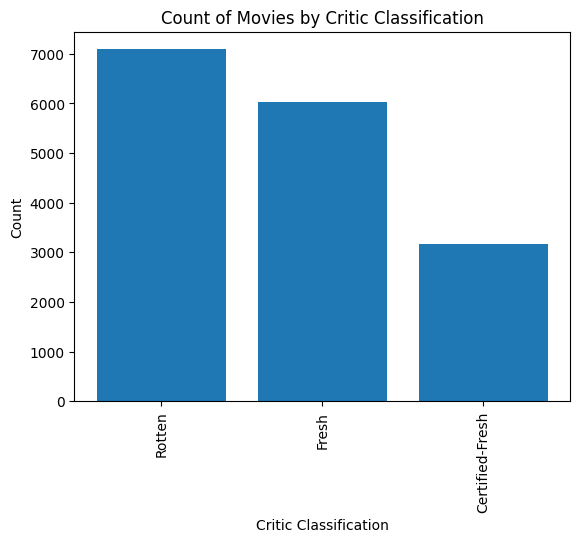

In [13]:
#Tomato Status count
make_bar_chart_from_frequencies(
    'tomatometer_status',len(df['content_rating'].value_counts()),'Critic Classification'
)

#### 2.) What are the parameters for the RT rating statuses?

In [14]:
#Critic rating metrics
tomato_df = df.groupby(['tomatometer_status'], as_index=False).agg({
    'tomatometer_rating': ['median','min','max']
})
tomato_df.head()

tomatometer_status tomatometer_rating             
                                 median   min    max
0    Certified-Fresh               88.0  70.0  100.0
1              Fresh               79.0  60.0  100.0
2             Rotten               33.0   0.0   59.0

In [15]:
#Audience rating metrics
tomato_df = df.groupby(['audience_status'], as_index=False).agg({
    'audience_rating': ['median','min','max']
})
tomato_df.head()

audience_status audience_rating             
                           median   min    max
0         Spilled            43.0   0.0   59.0
1         Upright            76.0  60.0  100.0

#### 3.) How have reviews changed over time?

/var/folders/yr/521qh_vn01n7j762jny9bmhw0000gn/T/ipykernel_67975/1312588409.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=90);


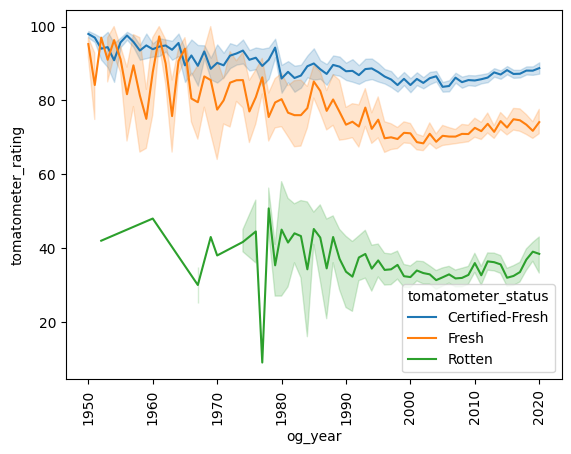

In [16]:
import seaborn as sns


def line_plot_function(df_to_use,filter_count,filter_year,yaxis_var,category):
    #Set up dataframe
    line_df = df_to_use[df_to_use['tomatometer_count']>=filter_count]
    line_df = line_df[line_df['og_year']>=filter_year]
    line_df = line_df[['og_year',f'{yaxis_var}',f'{category}']]
    line_df.groupby(['og_year',f'{category}'])[f'{yaxis_var}'].sum()
    line_df = line_df.sort_values(by='og_year',ascending=True)
    #Plot data
    line_plot = sns.lineplot(x="og_year", y=f"{yaxis_var}", hue=f"{category}", data=line_df)
    line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=90);

#Critic Ratings by RT status
line_plot_function(df,30,1950,'tomatometer_rating','tomatometer_status')

/var/folders/yr/521qh_vn01n7j762jny9bmhw0000gn/T/ipykernel_67975/1312588409.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=90);


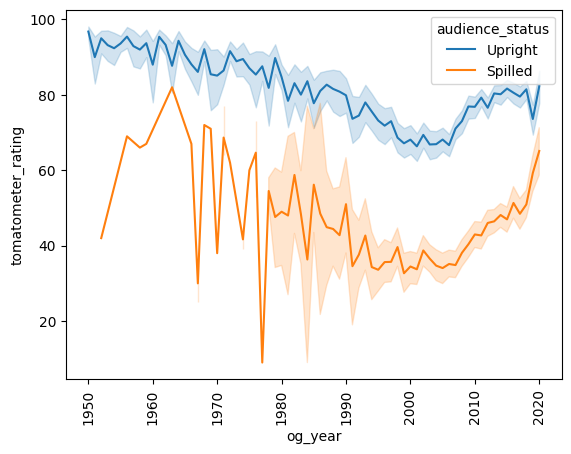

In [17]:
#Critic Ratings by Audience Status
line_plot_function(df,30,1950,'tomatometer_rating','audience_status')

In [18]:
#Get a list of top 20 production companies
prod_comp_df = pd.DataFrame(df['production_company'].value_counts().head(10)).reset_index()
pc_list = prod_comp_df['index'].values.tolist()
pc_list

['Paramount Pictures',
 'Warner Bros. Pictures',
 'Universal Pictures',
 '20th Century Fox',
 'IFC Films',
 'Sony Pictures Home Entertainment',
 'Warner Home Video',
 'MGM',
 'Sony Pictures Classics',
 'Magnolia Pictures']

/var/folders/yr/521qh_vn01n7j762jny9bmhw0000gn/T/ipykernel_67975/1312588409.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=90);


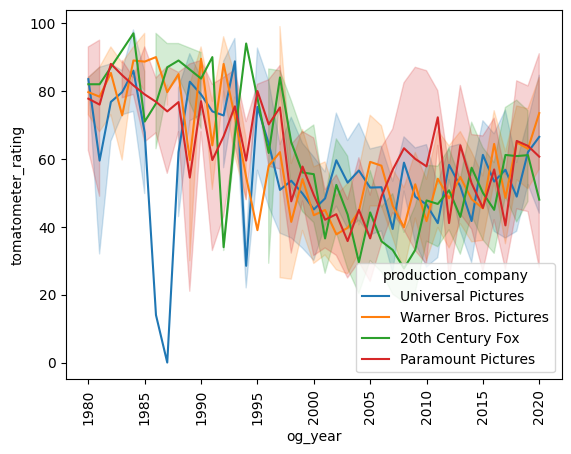

In [19]:
#Critic Ratings by Production Company
df_pc = df[df['production_company'].isin(['Paramount Pictures','Warner Bros. Pictures','Universal Pictures','20th Century Fox'])]

line_plot_function(df_pc,30,1980,'tomatometer_rating','production_company')

In [20]:
#Grab list of top 20 genres
top_genre_df = pd.DataFrame(df['genres'].value_counts().head(20)).reset_index()
genre_list = top_genre_df['index'].values.tolist()
genre_list

['Drama',
 'Comedy',
 'Comedy, Drama',
 'Drama, Mystery & Suspense',
 'Art House & International, Drama',
 'Documentary, Special Interest',
 'Documentary',
 'Horror',
 'Action & Adventure, Drama',
 'Action & Adventure, Drama, Mystery & Suspense',
 'Horror, Mystery & Suspense',
 'Comedy, Drama, Romance',
 'Drama, Romance',
 'Comedy, Romance',
 'Art House & International, Comedy, Drama',
 'Mystery & Suspense',
 'Action & Adventure, Mystery & Suspense',
 'Classics, Drama',
 'Action & Adventure',
 'Action & Adventure, Science Fiction & Fantasy']

/var/folders/yr/521qh_vn01n7j762jny9bmhw0000gn/T/ipykernel_67975/1312588409.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=90);


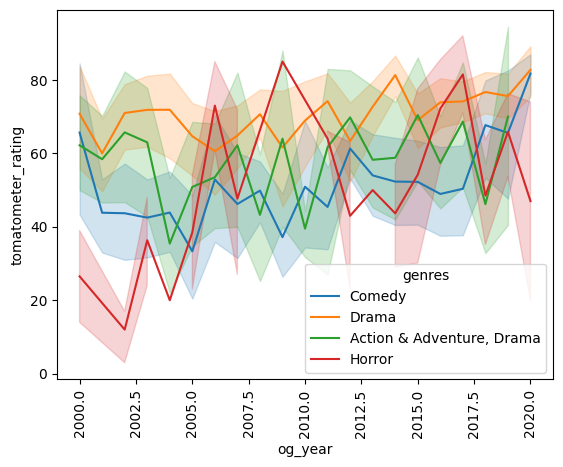

In [21]:
#Critic Rating by Genre
df_genre = df[df['genres'].isin(['Horror','Drama','Comedy','Action & Adventure, Drama'])]

line_plot_function(df_genre,100,2000,'tomatometer_rating','genres')

/var/folders/yr/521qh_vn01n7j762jny9bmhw0000gn/T/ipykernel_67975/1312588409.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=90);


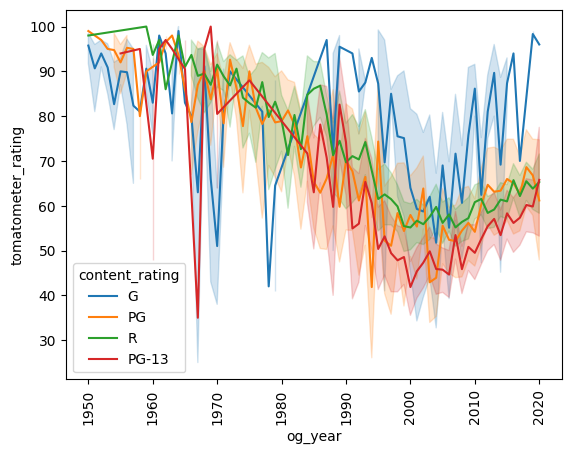

In [22]:
#Critic Rating by Movie Rating
df_ratings = df[df['content_rating'].isin(['G','PG','PG-13','R'])]

line_plot_function(df_ratings,30,1950,'tomatometer_rating','content_rating')

#### 4.) How has runtime changed over time?

/var/folders/yr/521qh_vn01n7j762jny9bmhw0000gn/T/ipykernel_67975/1312588409.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=90);


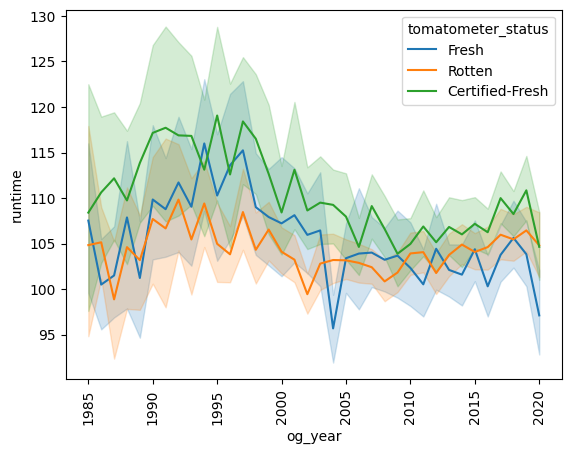

In [23]:
#Runtime by RT Status
line_plot_function(df,30,1985,'runtime','tomatometer_status')

/var/folders/yr/521qh_vn01n7j762jny9bmhw0000gn/T/ipykernel_67975/1312588409.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=90);


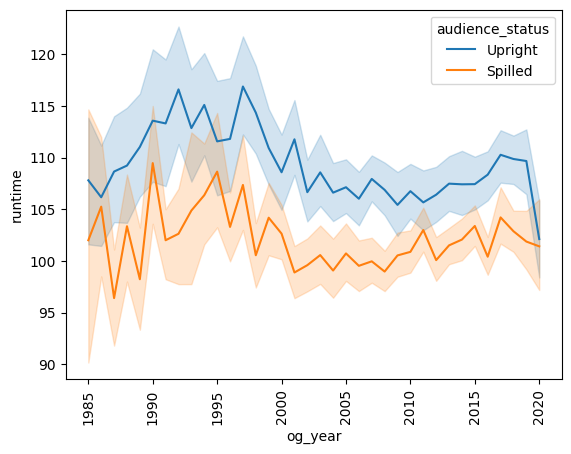

In [24]:
#Runtime by Audience Status
line_plot_function(df,30,1985,'runtime','audience_status')

/var/folders/yr/521qh_vn01n7j762jny9bmhw0000gn/T/ipykernel_67975/1312588409.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=90);


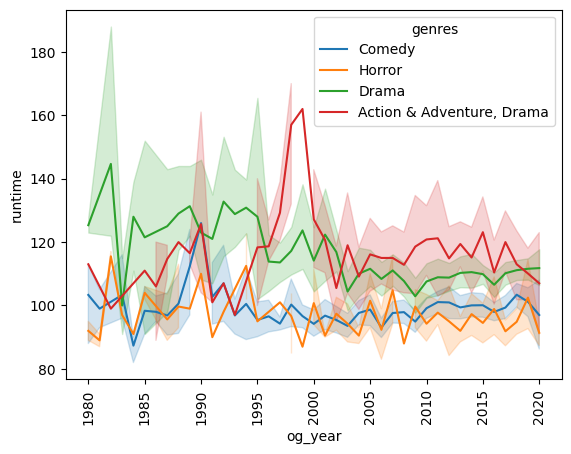

In [25]:
#Runtime by Genre
df_genre = df[df['genres'].isin(['Horror','Drama','Comedy','Action & Adventure, Drama'])]

line_plot_function(df_genre,30,1980,'runtime','genres')

/var/folders/yr/521qh_vn01n7j762jny9bmhw0000gn/T/ipykernel_67975/1312588409.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=90);


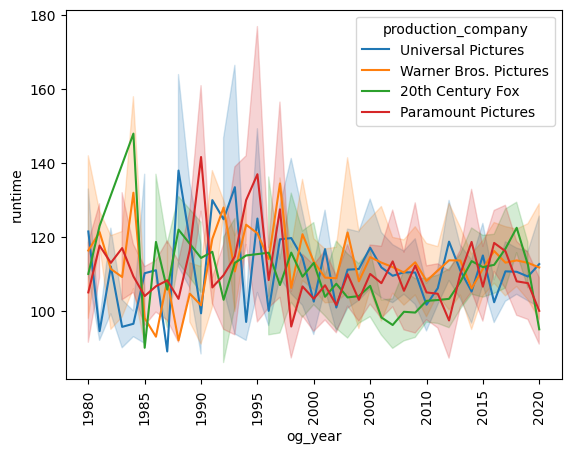

In [26]:
#Runtime by Production Company
df_pc = df[df['production_company'].isin(['Paramount Pictures','Warner Bros. Pictures','Universal Pictures','20th Century Fox'])]

line_plot_function(df_pc,30,1980,'runtime','production_company')

/var/folders/yr/521qh_vn01n7j762jny9bmhw0000gn/T/ipykernel_67975/1312588409.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  line_plot.set_xticklabels(line_plot.get_xticklabels(), rotation=90);


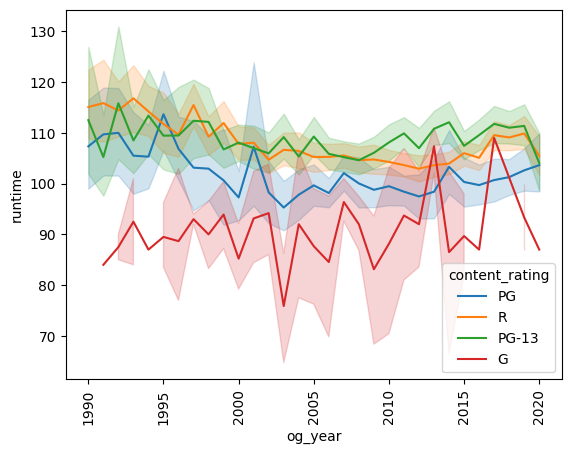

In [27]:
#Runtime by Movie Rating
df_ratings = df[df['content_rating'].isin(['G','PG','PG-13','R'])]


line_plot_function(df_ratings,30,1990,'runtime','content_rating')